# Violence Detection using CNN + LSTM neural network

## Introduction

With the increasing of surveillance cameras in modern cities, huge amount of videos can be collected. While there are insufficient human resource for monitoring all the screens at one time.

We are considering how to use techniques of video understanding to detect violent behavior so that it can give a quick alarm in time.

## Flowchart

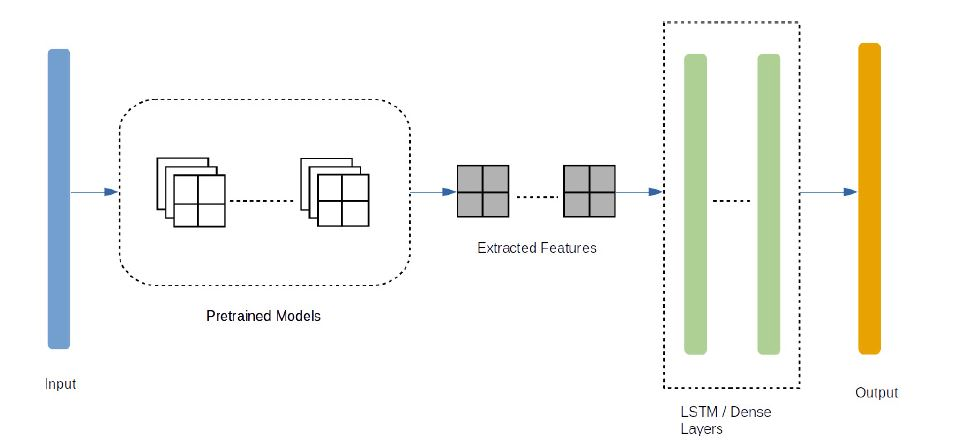




## Imports

In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation , Dropout
import sys
import h5py

## Helper Functions

We will use the function ```print_progress``` to print the amount of videos processed the datasets

In [2]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

## Load Data

Firstly, we define the directory to place the video dataset

In [3]:
in_dir = "D:\\Violence-Detection-Python-main\\RWF-2000\\train\\fight"

Copy some of the data-dimensions for convenience.

In [4]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 100

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".avi"

### Helper-function for getting video frames
Function used to get 100 frames from a video file and convert the frame to a suitable format for the neural net.

In [5]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

### Helper function to get the names of the data downloaded and label it

In [6]:
import random

In [7]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

### Plot a video frame to see if data is correct

In [8]:
# First get the names and labels of the whole videos
names, labels = label_video_names(in_dir)

Then we are going to load 100 frames of one video, for example

In [9]:
names[12]

'no636.avi'

The video has violence, look at the name of the video, starts with 'fi'

In [10]:
frames = get_frames(in_dir, names[12])

Convert back the frames to uint8 pixel format to plot the frame

In [11]:
visible_frame = (frames*255).astype('uint8')

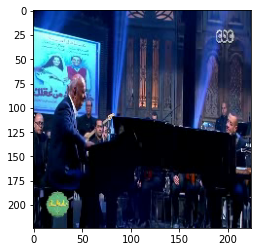

In [12]:
plt.imshow(visible_frame[3])

## Pre-Trained Model: VGG16

The following creates an instance of the pre-trained VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already.

The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If include_top=True then the whole VGG16 model is downloaded. If include_top=False then only the convolutional part of the VGG16 model is downloaded .

In [13]:
vid_model = VGG16(include_top=True, weights='imagenet')

Let's see the model summary

In [14]:
vid_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We can observe the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3. Note that we have defined the frame size as 224x224x3. The video frame will be the input of the VGG16 net.

### VGG16 model flowchart

The following chart shows how the data flows when using the VGG16 model for Transfer Learning. First we input and process 100 video frames in batch with the VGG16 model. Just prior to the final classification layer of the VGG16 model, we save the so-called Transfer Values to a cache-file.


In [15]:
# We will use the output of the layer prior to the final
# classification-layer which is named fc2. This is a fully-connected (or dense) layer.
transfer_layer = vid_model.get_layer('fc2')

image_model_transfer = Model(inputs=vid_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(vid_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


### Generator that process one video through VGG16 each function call

In [16]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
         # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([100,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

### Functions to save transfer values from VGG16 to later use
We are going to define functions to get the transfer values from VGG16 with defined number of files. Then save the transfer values files used from training in one file and the ones uses for testing in another one. 

In [17]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [18]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

### Split the dataset into training set and test set
We are going to split the dataset into training set and testing. The training set is used to train the model and the test set to check the model accuracy.

In [19]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)
names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

Then we are going to process all video frames through VGG16 and save the transfer values.

In [20]:
make_files(training_set)

- Progress: 0.5%

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
make_files_test(test_set)

- Progress: 99.7%

### Load the cached transfer values into memory
We have already saved all the videos transfer values into disk. But we have to load those transfer values into memory in order to train the LSTM net. One question would be: why not process transfer values and load them into RAM memory? Yes is a more eficient way to train the second net. But if you have to train the LSTM in different ways in order to see which way gets the best accuracy, if you didn't save the transfer values into disk you would have to process the whole videos each training. It's very time consuming processing the videos through VGG16 net. 


In order to load the saved transfer values into RAM memory we are going to use this two functions:

In [ ]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=100
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=100
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
data, target = process_alldata_training()

In [ ]:
data_test, target_test = process_alldata_test()

## Recurrent Neural Network

### Define LSTM architecture

When defining the LSTM architecture we have to take into account the dimensions of the transfer values. From each frame the VGG16 network obtains as output a vector of 4096 transfer values. From each video we are processing 100 frames so we will have 100 x 4096 values per video. The classification must be done taking into account the 100 frames of the video. If any of them detects violence, the video will be classified as violent.


The first input dimension of LSTM neurons is the temporal dimension, in our case it is 100. The second is the size of the features vector (transfer values).


In [ ]:
chunk_size = 4096
n_chunks = 100
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

## Model training


In [ ]:
epoch = 100
batchS = 500

history = model.fit(np.array(data[0:1200]), np.array(target[0:1200]), epochs=epoch,
                    validation_data=(np.array(data[1200:]), np.array(target[1200:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/100
3/3 - 5s - loss: 0.7555 - accuracy: 0.5067 - val_loss: 0.6975 - val_accuracy: 0.5125
Epoch 2/100
3/3 - 2s - loss: 0.7397 - accuracy: 0.4842 - val_loss: 0.6912 - val_accuracy: 0.5125
Epoch 3/100
3/3 - 2s - loss: 0.7241 - accuracy: 0.4842 - val_loss: 0.6938 - val_accuracy: 0.4875
Epoch 4/100
3/3 - 2s - loss: 0.7097 - accuracy: 0.4958 - val_loss: 0.6909 - val_accuracy: 0.5125
Epoch 5/100
3/3 - 2s - loss: 0.7079 - accuracy: 0.4950 - val_loss: 0.6902 - val_accuracy: 0.6750
Epoch 6/100
3/3 - 2s - loss: 0.6996 - accuracy: 0.5092 - val_loss: 0.6904 - val_accuracy: 0.4875
Epoch 7/100
3/3 - 2s - loss: 0.6970 - accuracy: 0.5158 - val_loss: 0.6910 - val_accuracy: 0.4875
Epoch 8/100
3/3 - 2s - loss: 0.6971 - accuracy: 0.4942 - val_loss: 0.6904 - val_accuracy: 0.4875
Epoch 9/100
3/3 - 2s - loss: 0.6945 - accuracy: 0.5225 - val_loss: 0.6898 - val_accuracy: 0.6125
Epoch 10/100
3/3 - 2s - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6894 - val_accuracy: 0.7250
Epoch 11/100
3/3 - 2s - loss:

Epoch 85/100
3/3 - 2s - loss: 0.5483 - accuracy: 0.7375 - val_loss: 0.5342 - val_accuracy: 0.7375
Epoch 86/100
3/3 - 2s - loss: 0.5521 - accuracy: 0.7300 - val_loss: 0.5530 - val_accuracy: 0.6875
Epoch 87/100
3/3 - 2s - loss: 0.5541 - accuracy: 0.7233 - val_loss: 0.5492 - val_accuracy: 0.7125
Epoch 88/100
3/3 - 2s - loss: 0.5614 - accuracy: 0.7142 - val_loss: 0.5581 - val_accuracy: 0.6750
Epoch 89/100
3/3 - 2s - loss: 0.5701 - accuracy: 0.7217 - val_loss: 0.5542 - val_accuracy: 0.6750
Epoch 90/100
3/3 - 2s - loss: 0.5663 - accuracy: 0.7125 - val_loss: 0.5535 - val_accuracy: 0.6750
Epoch 91/100
3/3 - 2s - loss: 0.5475 - accuracy: 0.7300 - val_loss: 0.5377 - val_accuracy: 0.7125
Epoch 92/100
3/3 - 2s - loss: 0.5467 - accuracy: 0.7333 - val_loss: 0.5565 - val_accuracy: 0.6625
Epoch 93/100
3/3 - 2s - loss: 0.5357 - accuracy: 0.7442 - val_loss: 0.5422 - val_accuracy: 0.7375
Epoch 94/100
3/3 - 2s - loss: 0.5523 - accuracy: 0.7375 - val_loss: 0.5830 - val_accuracy: 0.6875
Epoch 95/100
3/3 - 2

## Test the model

We are going to test the model with 20 % of the total videos. This videos have not been used to train the network. 

In [ ]:
result = model.evaluate(np.array(data_test), np.array(target_test))

10/10 [==============================] - 1s 42ms/step - loss: 0.6189 - accuracy: 0.7031


## Print the model accuracy

In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.6188818216323853
accuracy 0.703125


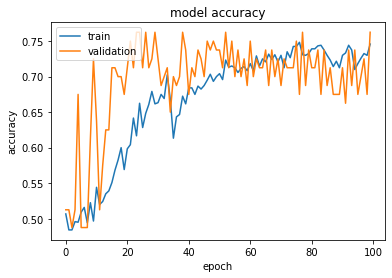

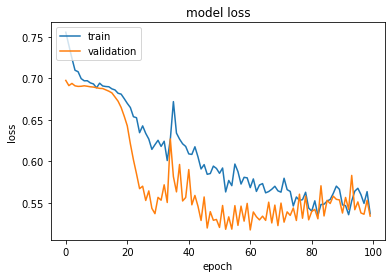

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

### Problems

Since all the videos are captured by surveillance cameras in public places, many of them may not have a good imaging quality due to dark environment, fast movement of object, lighting blur, etc.

### recommendation

I did not use all the data that I have because to train this model on a larger amount of data than this one needs super machine, and when training the model I noticed that the more data the amount >>> the more accurate the model.
That is why it would be great to use a larger amount of data with a super computer

This is why i see that the 70% accuracy is a satisfactory result .